# 0. Getting setup

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
import torch
import torchvision
print(f"torch version {torch.__version__}")
print(f"torchvision version {torchvision.__version__}")

torch version 1.13.0+cu117
torchvision version 0.14.0+cu117


In [10]:
# set seeds
def set_seeds(seed:int=42):
    """
    Sets random sets for torch operations.
    :param seed: (int, optional) Random seed to set. Defaults to 42.
    :return: Nothing to return.
    """
    # Set seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations
    torch.cuda.manual_seed(seed)

In [11]:
# Continue with regular imports
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [12]:
# setup device-agnostic code to make sure our models run on the GPU.
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 1. Get data

In [13]:
import os
import zipfile
from pathlib import Path
import requests

def download_data(source:str,destination: str,remove_source: bool=True)->Path:
    """
    Downloads a zipped dataset from source and unzios to destination.
    :param source: A link to a zipped file containing data.
    :param destination: A target directory to unzip data to.
    :param remove_source: Whether to remove the source after downloading and extracting.
    :return:pathlib.Path to downloaded data.
    """
    # Setup path to data folder
    data_path=Path("data/")
    image_path=data_path / destination
    # If the image folder doesn't exist , download it and prepare it ..
    if image_path.is_dir():
        print(f"[INFO {image_path} directory exists , skippingg download.")
    else:
        print (f"[INFO] Did not find {image_path} directory , creating one... ")
        image_path.mkdir(parents=True,exist_ok=True)

        # Downloading Pizza, Steak ,Sushi data
        target_file=Path(source).name
        with open(data_path / target_file ,"wb")as f:
            request=requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza ,steak , sushi Data
        with zipfile.ZipFile(data_path / target_file ,"r") as zip_ref :
            print(f"[INFO] unzipping {target_file}data..")
            zip_ref.extractall(image_path)

        # Remove .Zip file
        if remove_source :
            os.remove(data_path / target_file)
        return image_path

In [24]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",destination="pizza_steak_sushi_20_percent")
data_20_percent_path

[INFO data/pizza_steak_sushi_20_percent directory exists , skippingg download.


In [25]:
# Setup directory paths to train and test images
train_dir = r"/home/fox/AICoding/Food Vision app/data/pizza_steak_sushi_20_percent/train"
test_dir  = r"/home/fox/AICoding/Food Vision app/data/pizza_steak_sushi_20_percent/test"

# 2.0 Creating an EffNetB1 feature extractor

In [14]:
def create_effnetb1_model(num_classes:int=3,seed:int=42):
    """
    Creates an EFFicientNetB1 feature extractor model and transforms.
    :param num_classes: number of classes in classifier head.
                        Defaults to 3.
    :param seed: random seed value.
                 Defaults to 42.
    :return: feature extractor model.
         transforms (torchvision.transforms): EffNetB1 image transforms.
    """
    # 1. Setup pretrained EffNetB1 weights
    weigts = torchvision.models.EfficientNet_B1_Weights.DEFAULT
    # 2. Get EffNetB2 transforms
    transforms= weigts.transforms()

    # 3. Setup pretrained model
    model=torchvision.models.efficientnet_b1(weights= "DEFAULT")

    # 4. Freeze the base layers in the model (this will freeze all layers to begin with)
    for param in model.parameters():
        param.requires_grad=False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier=nn.Sequential(nn.Dropout(p=0.2,inplace=True),
                                   nn.Linear(in_features=1280,out_features=num_classes))
    return model,transforms

In [27]:
effnetb1,effnetb1_transforms=create_effnetb1_model(num_classes=3,seed=42)

In [28]:
from  torchinfo import summary
# Print EffNetB2 model summary
summary(effnetb1,input_size=(1,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=18,row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape        Output Shape       Param #            Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]   [1, 3]             --                 Partial
├─Sequential (features)                                      [1, 3, 224, 224]   [1, 1280, 7, 7]    --                 False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]   [1, 32, 112, 112]  --                 False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]   [1, 32, 112, 112]  (864)              False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]  [1, 32, 112, 112]  (64)               False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]  [1, 32, 112, 112]  --                 --
│    └─Sequential (1)                                        [1, 32, 112, 112]  [1, 16, 112, 112]  --                 False
│    

# 2.1 Creating DataLoaders for EffNetB1

In [15]:
import  os
from torchvision import  transforms,datasets
from  torch .utils.data import  DataLoader

NUM_WORKERS =os.cpu_count()
def create_dataloaders(train_dir:str,test_dir:str,transform:transforms.Compose,
                       batch_size:int,num_workers:int=NUM_WORKERS):
    """
    Creates training and testing DataLoaders.
    Takes in a training directory and testing directory path and turns them into PyTorch Datasets and then into PyTorch DataLoaders.

    :param train_dir: Path to training directory.
    :param test_dir: Path to testing directory.
    :param transform: torchvision transforms to perform on training and testing data.
    :param batch_size: Number of samples per batch in each of the DataLoaders.
    :param num_workers: An integer for number of workers per DataLoader.
    :return:
           A tuple of (train_dataloader, test_dataloader, class_names).
           Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
    """
    # Use ImageFolder to create dataset
    train_data=datasets.ImageFolder(train_dir,transform=transform)
    test_data=datasets.ImageFolder(test_dir,transform=transform)

    # Get class names
    class_names=train_data.classes

    # Turn Images into data loaders
    train_dataloader=DataLoader(train_data,batch_size=batch_size,shuffle=True,
                                num_workers=num_workers,pin_memory=True)
    test_dataloader=DataLoader(test_data,batch_size=batch_size,shuffle=True,
                               num_workers=num_workers,pin_memory=True)
    return train_dataloader,test_dataloader,class_names

In [30]:
train_dataloader_effnetb1,test_dataloader_effnetb1,class_names=create_dataloaders(train_dir=train_dir,test_dir=test_dir,
                                                                                  transform=effnetb1_transforms,batch_size=32)

# 2.2 Training EffNetB1 feature extractor

In [16]:
from typing import Dict,List,Tuple
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data .DataLoader,
               loss_fn:torch.nn.Module,optimizer:torch.optim.Optimizer,
               device:torch.device)->Tuple[float,float]:
    """
    Trains a PyTorch model for a single epoch.
    Turns a target PyTorch model to training mode and then runs through all of the required training steps
    (forward pass, loss calculation, optimizer step).
    :param model: A PyTorch model to be trained.
    :param dataloader: A DataLoader instance for the model to be trained on.
    :param loss_fn: A PyTorch loss function to minimize.
    :param optimizer: A PyTorch optimizer to help minimize the loss function.
    :param device: A target device to compute on (e.g. "cuda" or "cpu").
    :return:
     A tuple of training loss and training accuracy metrics.
     In the form (train_loss, train_accuracy).
     For example: (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc =0, 0

    # Loop through data loader , data batches
    for batch ,(X,y) in enumerate(dataloader):
        # send data to target device
        X, y=X.to(device) , y.to(device)

        # 1. Forward pass
        y_pred = model(X)
        # 2. Calculate and accumulate loss
        loss=loss_fn(y_pred,y)
        train_loss += loss.item()
        # 3. Optimizer zero grade
        optimizer.zero_grad()
        # 4. Loss backward
        loss.backward()
        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
        train_acc += ((y_pred_class == y).sum().item())/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss/ len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss ,train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """
    Tests a PyTorch model for a single epoch.
    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.
    :param model: A PyTorch model to be tested.
    :param dataloader: A DataLoader instance for the model to be tested on.
    :param loss_fn: A PyTorch loss function to calculate loss on the test data.
    :param device: A target device to compute on (e.g. "cuda" or "cpu").
    :return:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy).
    For example: (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval()

    #  Setup test loss and test accuracy values
    test_loss ,test_acc= 0,0

    # Turn on inference context manager
    with torch.inference_mode():
        for batch , (X,y) in enumerate(dataloader):
            #  Send data to target device
            X, y= X.to(device) , y.to(device)

            # 1. Forward pass
            test_pred_logits= model(X)

            # 2. Calculate and accumulate loss
            loss =loss_fn(test_pred_logits,y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item())/len(test_pred_labels)
    # Adjust metrics to get average loss and accuracy per batch
    test_loss =test_loss/ len(dataloader)
    test_acc = test_acc / len(dataloader)
    return  test_loss , test_acc

def train (model: torch.nn.Module,
           train_dataloader: torch.utils.data.DataLoader,
           test_dataloader: torch.utils.data.DataLoader,
           optimizer: torch.optim.Optimizer,
           loss_fn: torch.nn.Module,
           epochs: int,
           device: torch.device) -> Dict[str, List]:
    """
    Trains and tests a PyTorch model.
    Passes a target PyTorch models through train_step() and test_step() functions for a number of epochs, training and testing the model in the same epoch loop.
    Calculates, prints and stores evaluation metrics throughout.

    :param model: A PyTorch model to be trained and tested.
    :param train_dataloader: A DataLoader instance for the model to be trained on.
    :param test_dataloader: A DataLoader instance for the model to be tested on.
    :param optimizer: A PyTorch optimizer to help minimize the loss function.
    :param loss_fn: A PyTorch loss function to calculate loss on both datasets.
    :param epochs: An integer indicating how many epochs to train for.
    :param device: A target device to compute on (e.g. "cuda" or "cpu").
    :return:
    A dictionary of training and testing loss as well as training and testing accuracy metrics.
    Each metric has a value in a list for each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
              t   test_loss: [...],
                  test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss":[],
               "train_acc":[],
               "test_loss":[],
               "test_acc":[]}

    # Loop through training and testing steps for a number of epochs
    for epoch in range(epochs):
        train_loss , train_acc = train_step(model=model,
                                            dataloader=train_dataloader,
                                            loss_fn=loss_fn,
                                            optimizer=optimizer,
                                            device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f}")

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [32]:
# setup optimizer
optimizer=torch.optim.Adam(params=effnetb1.parameters(),lr=1e-3)

# setup loss function
loss_fn=torch.nn.CrossEntropyLoss()

# Set seeds for reproducibility and train the model
set_seeds()

effnetb1_results= train(model=effnetb1,
                        train_dataloader=train_dataloader_effnetb1,
                        test_dataloader=test_dataloader_effnetb1,
                        epochs=25,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        device=device)

Epoch: 1 | train_loss: 1.0049 | train_acc: 0.6333 | test_loss: 0.8496 | test_acc: 0.9102
Epoch: 2 | train_loss: 0.8312 | train_acc: 0.8521 | test_loss: 0.7013 | test_acc: 0.9222
Epoch: 3 | train_loss: 0.6546 | train_acc: 0.8979 | test_loss: 0.6163 | test_acc: 0.9227
Epoch: 4 | train_loss: 0.5758 | train_acc: 0.9167 | test_loss: 0.5406 | test_acc: 0.9284
Epoch: 5 | train_loss: 0.5117 | train_acc: 0.9167 | test_loss: 0.4758 | test_acc: 0.9506
Epoch: 6 | train_loss: 0.4659 | train_acc: 0.8833 | test_loss: 0.4300 | test_acc: 0.9381
Epoch: 7 | train_loss: 0.4239 | train_acc: 0.9104 | test_loss: 0.3929 | test_acc: 0.9347
Epoch: 8 | train_loss: 0.4031 | train_acc: 0.9333 | test_loss: 0.3603 | test_acc: 0.9563
Epoch: 9 | train_loss: 0.3614 | train_acc: 0.9271 | test_loss: 0.3619 | test_acc: 0.9568
Epoch: 10 | train_loss: 0.3302 | train_acc: 0.9458 | test_loss: 0.3312 | test_acc: 0.9625
Epoch: 11 | train_loss: 0.3348 | train_acc: 0.9313 | test_loss: 0.3187 | test_acc: 0.9597
Epoch: 12 | train_l

# 2.3 Inspecting EffNetB1 loss curves

In [17]:
def plot_loss_curves(results):
    """
    Plots training curves of a results dictionary.
    :param results: dictionary containing list of values, e.g.
                    {"train_loss": [...],
                     "train_acc": [...],
                     "test_loss": [...],
                     "test_acc": [...]}
    :return: loss curves
    """

    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

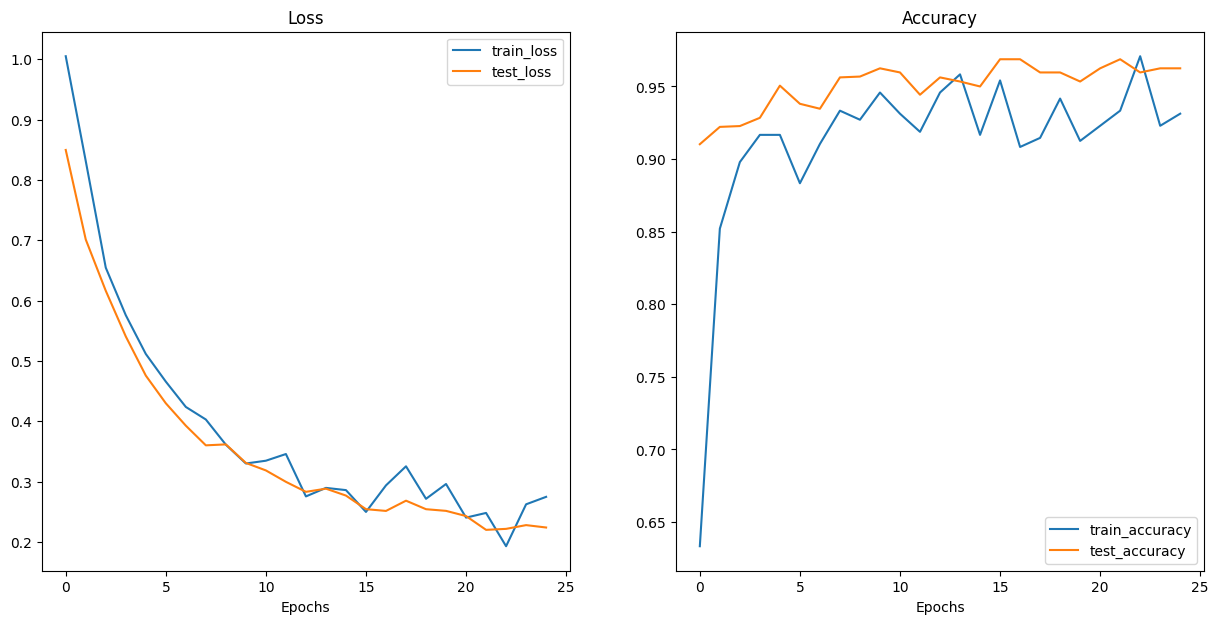

In [34]:
plot_loss_curves(effnetb1_results)

# 2.4 Saving EffNetB1 feature extractor

In [18]:
from pathlib import Path
def save_model(model:torch.nn.Module,targt_dir:str,model_name:str):
    """
    Saves a PyTorch model to a target directory.
    :param model: A target PyTorch model to save.
    :param targt_dir: A directory for saving the model to.
    :param model_name: A filename for the saved model. Should include either ".pth" or ".pt" as the file extension.
    :Example usage:
          save_model(model=model_0,
                     target_dir="models",
                     model_name="05_going_modular_tingvgg_model.pth")
    """
    # Create target directory
    target_dir_path= Path(targt_dir)
    target_dir_path.mkdir(parents=True,exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth")or model_name.endswith(".pt"),"model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save model state_dict()
    print(f"[INFO] Saving model to : {model_save_path}")
    torch.save(obj=model.state_dict(),f=model_save_path)

In [36]:
# Save the model
save_model(model=effnetb1,targt_dir="models",model_name="pretrained_effnetb1_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to : models/pretrained_effnetb1_feature_extractor_pizza_steak_sushi_20_percent.pth


# 2.5 Checking the size of EffNetB1 feature extractor

In [37]:
# Get the model size in bytes then convert to megabytes
pretrained_effnetb1_model_size = Path("models/pretrained_effnetb1_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained EffNetB1 feature extractor model size: {pretrained_effnetb1_model_size} MB")

Pretrained EffNetB1 feature extractor model size: 25 MB


# 2.6 Collecting EffNetB1 feature extractor stats

In [38]:
# Count number of parameters in EffNetB1
effnetb1_total_params = sum(torch.numel(param) for param in effnetb1.parameters())
effnetb1_total_params

6517027

In [39]:
# Create a dictionary with EffNetB1 statistics
effnetb1_stats ={"test_loss": effnetb1_results["test_loss"][-1],
                 "test_acc":effnetb1_results["test_acc"][-1],
                 "number_of_parameters": effnetb1_total_params,
                 "model_size": pretrained_effnetb1_model_size}
effnetb1_stats

{'test_loss': 0.22419896125793456,
 'test_acc': 0.9625,
 'number_of_parameters': 6517027,
 'model_size': 25}

# 3.0 Creating a ViT feature extractor

In [40]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 3.
        seed (int, optional): random seed value for output layer. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model.
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes

    return model, transforms

In [41]:
# Create ViT model and transforms
vit, vit_transforms = create_vit_model(num_classes=3,
                                       seed=42)

In [42]:
# Print ViT feature extractor model summary (uncomment for full output)
summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=18,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape        Output Shape       Param #            Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]   [1, 3]             768                Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]   [1, 768, 14, 14]   (590,592)          False
├─Encoder (encoder)                                          [1, 197, 768]      [1, 197, 768]      151,296            False
│    └─Dropout (dropout)                                     [1, 197, 768]      [1, 197, 768]      --                 --
│    └─Sequential (layers)                                   [1, 197, 768]      [1, 197, 768]      --                 False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]      [1, 197, 768]      (7,087,872)        False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]      [1, 197, 768]      (7,087,872)        False
│    

# 3.1 Create DataLoaders for ViT

In [43]:
train_dataloader_vit, test_dataloader_vit, class_names = create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

# 3.2 Training ViT feature extractor

In [44]:
# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train ViT model with seeds set for reproducibility
set_seeds()
vit_results =train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=15,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2614 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.2197 | train_acc: 0.9437 | test_loss: 0.1492 | test_acc: 0.9688
Epoch: 3 | train_loss: 0.1534 | train_acc: 0.9583 | test_loss: 0.1125 | test_acc: 0.9750
Epoch: 4 | train_loss: 0.1304 | train_acc: 0.9604 | test_loss: 0.0961 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1079 | train_acc: 0.9688 | test_loss: 0.0821 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.0981 | train_acc: 0.9750 | test_loss: 0.0776 | test_acc: 0.9812
Epoch: 7 | train_loss: 0.0908 | train_acc: 0.9812 | test_loss: 0.0727 | test_acc: 0.9756
Epoch: 8 | train_loss: 0.0729 | train_acc: 0.9854 | test_loss: 0.0645 | test_acc: 0.9875
Epoch: 9 | train_loss: 0.0647 | train_acc: 0.9854 | test_loss: 0.0606 | test_acc: 0.9750
Epoch: 10 | train_loss: 0.0558 | train_acc: 0.9854 | test_loss: 0.0613 | test_acc: 0.9750
Epoch: 11 | train_loss: 0.0490 | train_acc: 0.9958 | test_loss: 0.0649 | test_acc: 0.9722
Epoch: 12 | train_l

# 3.3 Inspecting ViT loss curves

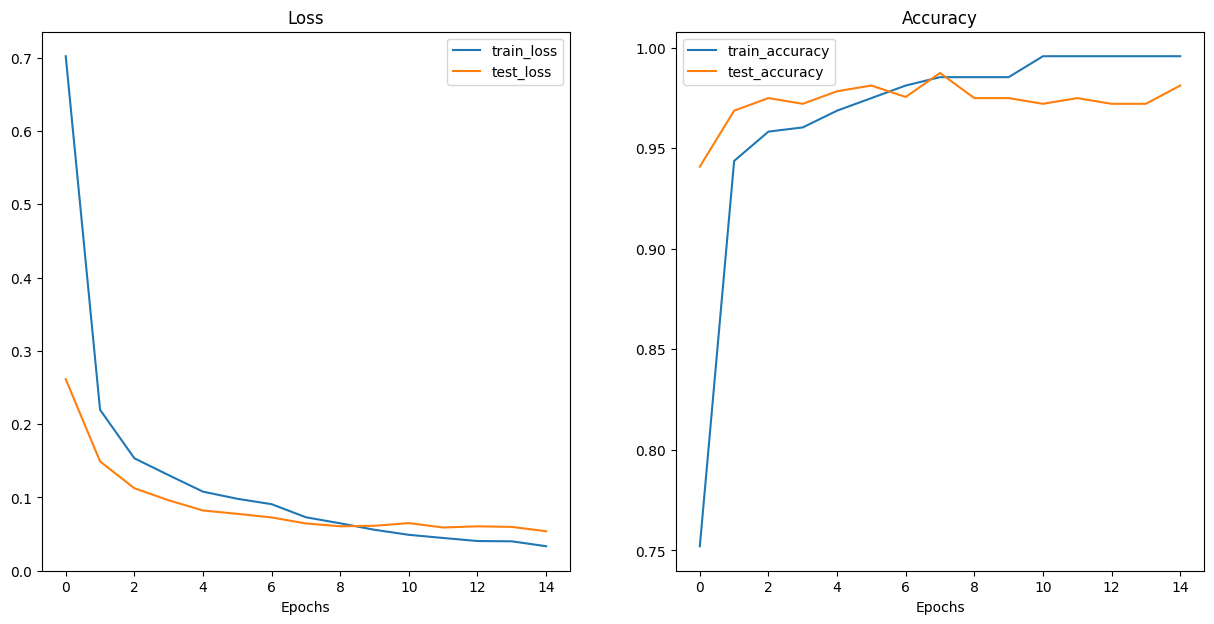

In [45]:
plot_loss_curves(vit_results)

# 3.4 Saving ViT feature extractor

In [46]:
# save the model
save_model(model=vit,targt_dir="models",model_name="pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to : models/pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


# 3.5 Checking the size of ViT feature extractor

In [47]:
# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size=Path("models/pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


# 3.6 Collecting ViT feature extractor stats

In [48]:
# Count number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [49]:
# Create ViT statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size": pretrained_vit_model_size}

vit_stats

{'test_loss': 0.05384576059877873,
 'test_acc': 0.98125,
 'number_of_parameters': 85800963,
 'model_size': 327}

# 4.0 Making predictions with our trained models and timing them

In [50]:
# Get all test data paths
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths=list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:-5]

[INFO] Finding all filepaths ending with '.jpg' in directory: /home/fox/AICoding/Food Vision app/data/pizza_steak_sushi_20_percent/test


[PosixPath('/home/fox/AICoding/Food Vision app/data/pizza_steak_sushi_20_percent/test/pizza/771336.jpg'),
 PosixPath('/home/fox/AICoding/Food Vision app/data/pizza_steak_sushi_20_percent/test/pizza/2782998.jpg'),
 PosixPath('/home/fox/AICoding/Food Vision app/data/pizza_steak_sushi_20_percent/test/pizza/441659.jpg'),
 PosixPath('/home/fox/AICoding/Food Vision app/data/pizza_steak_sushi_20_percent/test/pizza/296426.jpg'),
 PosixPath('/home/fox/AICoding/Food Vision app/data/pizza_steak_sushi_20_percent/test/pizza/2398925.jpg'),
 PosixPath('/home/fox/AICoding/Food Vision app/data/pizza_steak_sushi_20_percent/test/pizza/2901001.jpg'),
 PosixPath('/home/fox/AICoding/Food Vision app/data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
 PosixPath('/home/fox/AICoding/Food Vision app/data/pizza_steak_sushi_20_percent/test/pizza/2549661.jpg'),
 PosixPath('/home/fox/AICoding/Food Vision app/data/pizza_steak_sushi_20_percent/test/pizza/419962.jpg'),
 PosixPath('/home/fox/AICoding/Food Visio

# 4.1 Creating a function to make predictions across the test dataset

In [51]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from typing import List, Dict

def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
    """
    function that takes a list of paths, a trained PyTorch model, a series of transforms (to prepare images), a list of target class names and a target device.
    :param paths: A list of our test image paths.
    :param model: A PyTorch model used to prediction.
    :param transform: series of transforms (to prepare images).
    :param class_names: list of target class names.
    :param device: target device.
    :return: list of dictionaries with sample, truth label, prediction, prediction probability and prediction time.
    """
    # 1. Create an empty list to store prediction dictionaires
    pred_list = []

    # 2. loop through target paths
    for path in paths:
        # 3. Create empty dictionary to store prediction information for each sample
        pred_dict={}

        # 4. Get the sample path and ground truth class name
        pred_dict["image_path"]=path
        class_name=path.parent.stem
        pred_dict["class_name"]=class_name

        # 5. Start the prediction timer
        start_time = timer()
        # 6. open image path
        img =Image.open(path)

        # 7. Transform the image, add batch dimension and put image on target device
        transformed_image=transform(img).unsqueeze(0).to(device)

        # 8. Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()

        # 9. Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image)
            pred_prob = torch.softmax(pred_logit,dim=1)
            pred_label = torch.argmax(pred_prob ,dim=1)
            pred_class = class_names[pred_label.cpu()]

            # 10. Make sure things in the dictionary are on CPU (required for inspecting predictions later on)
            pred_dict["pred_prob"]=round(pred_prob.unsqueeze(0).max().cpu().item(),4)
            pred_dict["pred_class"] = pred_class
            # 11. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)
        # 12. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class
        # 13. Add the dictionary to the list of preds
        pred_list.append(pred_dict)

    return pred_list

# 4.2 Making and timing predictions with EffNetB1

In [52]:
# Make predictions across test dataset with EffNetB2
effnetb1_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb1,
                                          transform=effnetb1_transforms,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU

In [53]:
# Inspect the first 3 prediction dictionaries
effnetb1_test_pred_dicts[:3]

[{'image_path': PosixPath('/home/fox/AICoding/Food Vision app/data/pizza_steak_sushi_20_percent/test/pizza/771336.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.8886,
  'pred_class': 'pizza',
  'time_for_pred': 0.1134,
  'correct': True},
 {'image_path': PosixPath('/home/fox/AICoding/Food Vision app/data/pizza_steak_sushi_20_percent/test/pizza/2782998.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9626,
  'pred_class': 'pizza',
  'time_for_pred': 0.0704,
  'correct': True},
 {'image_path': PosixPath('/home/fox/AICoding/Food Vision app/data/pizza_steak_sushi_20_percent/test/pizza/441659.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.6561,
  'pred_class': 'pizza',
  'time_for_pred': 0.0719,
  'correct': True}]

In [54]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb1_test_pred_df = pd.DataFrame(effnetb1_test_pred_dicts)
effnetb1_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,/home/fox/AICoding/Food Vision app/data/pizza_...,pizza,0.8886,pizza,0.1134,True
1,/home/fox/AICoding/Food Vision app/data/pizza_...,pizza,0.9626,pizza,0.0704,True
2,/home/fox/AICoding/Food Vision app/data/pizza_...,pizza,0.6561,pizza,0.0719,True
3,/home/fox/AICoding/Food Vision app/data/pizza_...,pizza,0.9586,pizza,0.0678,True
4,/home/fox/AICoding/Food Vision app/data/pizza_...,pizza,0.9154,pizza,0.0738,True


In [55]:
# Check number of correct predictions
effnetb1_test_pred_df.correct.value_counts()

True     144
False      6
Name: correct, dtype: int64

In [56]:
# Find the average time per prediction
effnetb1_average_time_per_pred = round(effnetb1_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB1 average time per prediction: {effnetb1_average_time_per_pred} seconds")

EffNetB1 average time per prediction: 0.0661 seconds


In [57]:
# Add EffNetB2 average prediction time to stats dictionary
effnetb1_stats["time_per_pred_cpu"] = effnetb1_average_time_per_pred
effnetb1_stats

{'test_loss': 0.22419896125793456,
 'test_acc': 0.9625,
 'number_of_parameters': 6517027,
 'model_size': 25,
 'time_per_pred_cpu': 0.0661}

# 4.3 Making and timing predictions with ViT

In [58]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")

In [59]:
# Inspect the first 3 prediction dictionaries
vit_test_pred_dicts[:3]

[{'image_path': PosixPath('/home/fox/AICoding/Food Vision app/data/pizza_steak_sushi_20_percent/test/pizza/771336.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9987,
  'pred_class': 'pizza',
  'time_for_pred': 0.8826,
  'correct': True},
 {'image_path': PosixPath('/home/fox/AICoding/Food Vision app/data/pizza_steak_sushi_20_percent/test/pizza/2782998.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9994,
  'pred_class': 'pizza',
  'time_for_pred': 0.6869,
  'correct': True},
 {'image_path': PosixPath('/home/fox/AICoding/Food Vision app/data/pizza_steak_sushi_20_percent/test/pizza/441659.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9957,
  'pred_class': 'pizza',
  'time_for_pred': 0.6567,
  'correct': True}]

In [60]:
# Turn vit_test_pred_dicts into a DataFrame
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,/home/fox/AICoding/Food Vision app/data/pizza_...,pizza,0.9987,pizza,0.8826,True
1,/home/fox/AICoding/Food Vision app/data/pizza_...,pizza,0.9994,pizza,0.6869,True
2,/home/fox/AICoding/Food Vision app/data/pizza_...,pizza,0.9957,pizza,0.6567,True
3,/home/fox/AICoding/Food Vision app/data/pizza_...,pizza,0.9991,pizza,0.6355,True
4,/home/fox/AICoding/Food Vision app/data/pizza_...,pizza,0.9989,pizza,0.6489,True


In [61]:
# Count the number of correct predictions
vit_test_pred_df.correct.value_counts()

True     147
False      3
Name: correct, dtype: int64

In [62]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

ViT average time per prediction: 0.4048 seconds


In [63]:
# Add average prediction time for ViT model on CPU
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.05384576059877873,
 'test_acc': 0.98125,
 'number_of_parameters': 85800963,
 'model_size': 327,
 'time_per_pred_cpu': 0.4048}

# 5.0 Comparing model results, prediction times and size

In [64]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb1_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB1", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size,time_per_pred_cpu,model
0,0.224199,96.25,6517027,25,0.0661,EffNetB1
1,0.053846,98.12,85800963,327,0.4048,ViT


In [65]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB1"]), # divide ViT statistics by EffNetB2 statistics
             columns=["ViT to EffNetB1 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size,time_per_pred_cpu
ViT to EffNetB1 ratios,0.24017,1.019429,13.16566,13.08,6.124054


# 5.1 Visualizing the speed vs. performance tradeoff

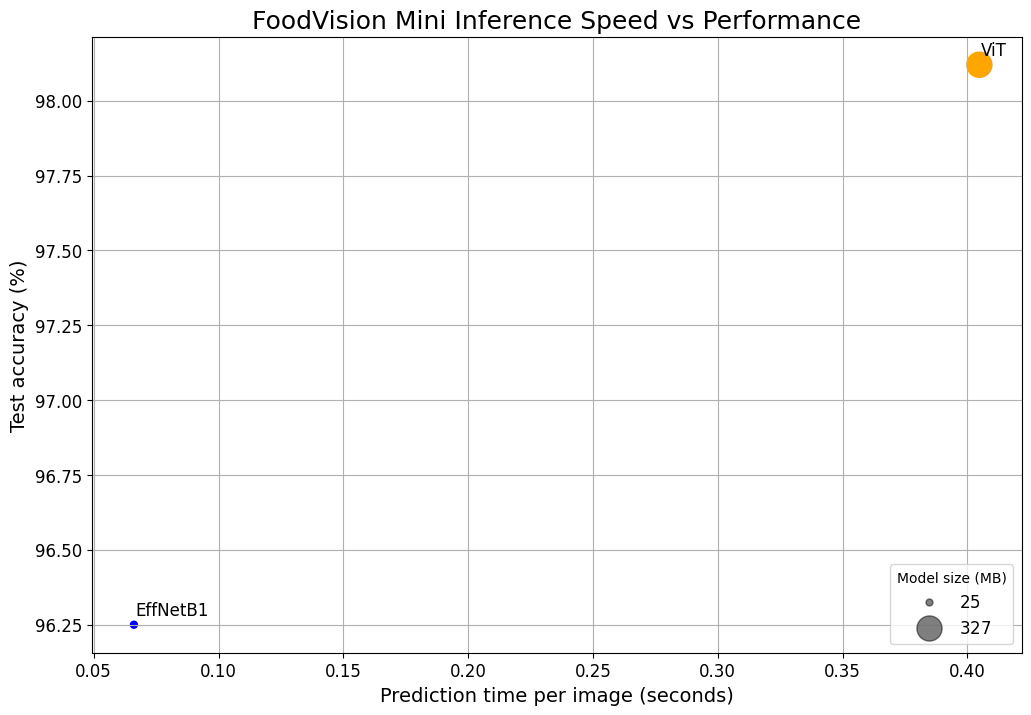

In [66]:
# 1. Create a plot from model comparison DataFrame
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"], # what colours to use?
                     s="model_size") # size the dots by the model sizes

# 2. Add titles, labels and customize fontsize for aesthetics
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# 3. Annotate with model names
for index, row in df.iterrows():
    ax.annotate(text=row["model"],
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)

# 4. Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="lower right",
                              title="Model size (MB)",
                              fontsize=12)

# Save the figure
plt.savefig("foodvision-mini-inference-speed-vs-performance.jpg")

# Show the figure
plt.show()

# 6.0 Bringing FoodVision Mini to life by creating a Gradio demo

##### <font color=ff00> Gradio is the fastest way to demo your machine learning model with a friendly web interface so that anyone can use it, anywhere!

In [67]:
# import or install Gradio
try:
    import  gradio as gr
except :
    !pip -q install gradio
    import gradio as gr
print(f"Gradio version: {gr.__version__}")

Gradio version: 3.16.2


# 6.1 Creating a function to map our inputs and outputs

In [68]:
# Put EffNetB2 on CPU
effnetb1.to("cpu")

# Check the device
next(iter(effnetb1.parameters())).device

device(type='cpu')

In [69]:
def predict(img)-> Tuple[Dict, float]:
    """
    Transforms and performs a prediction on img.
    :param img: target image .
    :return: prediction and time taken.
    """
    # Start the timer
    start_time=timer()
    # Transform the target image and add a batch dimension
    img = effnetb1_transforms(img).unsqueeze(0)
    # put model into evaluation mode and turn infarance mode
    effnetb1.eval()
    with torch.inference_mode():

        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs=torch.softmax(effnetb1(img),dim=1)
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)

    pred_labels_and_probs={class_names[i]:float(pred_probs[0][i]) for i in range(len(class_names))}
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

In [70]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: /home/fox/AICoding/Food Vision app/data/pizza_steak_sushi_20_percent/test/pizza/998005.jpg

Prediction label and probability dictionary: 
{'pizza': 0.7619388103485107, 'steak': 0.01779055967926979, 'sushi': 0.22027066349983215}
Prediction time: 0.04409 seconds


# 6.2 Building a Gradio interface

In [71]:
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['/home/fox/AICoding/Food Vision app/data/pizza_steak_sushi_20_percent/test/pizza/61656.jpg'],
 ['/home/fox/AICoding/Food Vision app/data/pizza_steak_sushi_20_percent/test/sushi/1944743.jpg'],
 ['/home/fox/AICoding/Food Vision app/data/pizza_steak_sushi_20_percent/test/sushi/46797.jpg']]

In [72]:
import gradio as gr

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB1 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "I will add it soon wait.."

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://f5e111c3-8adb-4cdc.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


# 7.0 Creating a demos folder to store our FoodVision Mini app files

In [73]:
import shutil
from  pathlib import  Path
# create foodvision mini demo path
foodvision_mini_demo_path = Path("demos/foodvision_mini")

# # Remove files that might already exist there and create new directory
if foodvision_mini_demo_path.exists():
    shutil.rmtree(foodvision_mini_demo_path)
    foodvision_mini_demo_path.mkdir(parents=True, # make the parent folders?
                                    exist_ok=True) # create it even if it already exists?
else:
    # If the file doesn't exist, create it anyway
    foodvision_mini_demo_path.mkdir(parents=True,
                                    exist_ok=True)

# Check what's in the folder
!ls demos/foodvision_mini/

# 7.1 Creating a folder of example images to use with our FoodVision Mini demo

In [74]:
import shutil
from pathlib import Path

# 1. Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)
# 2. Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]
# 3. Copy the three random images to the examples directory
for example in foodvision_mini_examples:
    destination = foodvision_mini_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/examples/2582289.jpg


In [75]:
# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/3622237.jpg'], ['examples/2582289.jpg'], ['examples/592799.jpg']]

# 7.2 Moving our trained EffNetB1 model to our FoodVision Mini demo directory

In [76]:
import shutil

# Create a source path for our target model
effnetb1_foodvision_mini_model_path = "models/pretrained_effnetb1_feature_extractor_pizza_steak_sushi_20_percent.pth"

# Create a destination path for our target model
effnetb1_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb1_foodvision_mini_model_path.split("/")[1]
# Try to move the file
try:
    print(f"[INFO] Attempting to move {effnetb1_foodvision_mini_model_path} to {effnetb1_foodvision_mini_model_destination}")

    # Move the model
    shutil.move(src=effnetb1_foodvision_mini_model_path, dst=effnetb1_foodvision_mini_model_destination)

    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {effnetb1_foodvision_mini_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {effnetb1_foodvision_mini_model_destination}: {effnetb1_foodvision_mini_model_destination.exists()}")

[INFO] Attempting to move models/pretrained_effnetb1_feature_extractor_pizza_steak_sushi_20_percent.pth to demos/foodvision_mini/pretrained_effnetb1_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] Model move complete.


# 7.3 Turning our EffNetB2 model into a Python script (model.py)

In [77]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision

from torch import nn


def create_effnetb1_model(num_classes:int=3,seed:int=42):
    """
    Creates an EFFicientNetB1 feature extractor model and transforms.
    :param num_classes: number of classes in classifier head.
                        Defaults to 3.
    :param seed: random seed value.
                 Defaults to 42.
    :return: feature extractor model.
         transforms (torchvision.transforms): EffNetB1 image transforms.
    """
    # 1. Setup pretrained EffNetB1 weights
    weigts = torchvision.models.EfficientNet_B1_Weights.DEFAULT
    # 2. Get EffNetB2 transforms
    transforms= weigts.transforms()

    # 3. Setup pretrained model
    model=torchvision.models.efficientnet_b1(weights= "DEFAULT")

    # 4. Freeze the base layers in the model (this will freeze all layers to begin with)
    for param in model.parameters():
        param.requires_grad=False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier=nn.Sequential(nn.Dropout(p=0.2,inplace=True),
                                   nn.Linear(in_features=1280,out_features=num_classes))
    return model,transforms

Writing demos/foodvision_mini/model.py


# 7.4 Turning our FoodVision Mini Gradio app into a Python script

In [78]:
%%writefile demos/foodvision_mini/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb1_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ["pizza", "steak", "sushi"]

### 2. Model and transforms preparation ###

# Create EffNetB2 model
effnetb1, effnetb1_transforms = create_effnetb1_model(num_classes=len(class_names) )

# Load saved weights
effnetb1.load_state_dict(torch.load(f="pretrained_effnetb1_feature_extractor_pizza_steak_sushi_20_percent.pth",
                                    map_location=torch.device("cpu"),))
### 3. Predict function ###
# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """
    Transforms and performs a prediction on img.
    :param img: target image .
    :return: prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb1_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb1.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb1(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB1 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "I will add it soon wait.."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/foodvision_mini/app.py


# 7.5 Creating a requirements file for FoodVision Mini (requirements.txt)

In [79]:
import torch
import torchvision
import  gradio as gr
print(f"Torch Version {torch.__version__}")
print(f"Torchvision Version {torchvision.__version__}")
print(f"Gradio Version {gr.__version__}")

Torch Version 1.13.1+cu117
Torchvision Version 0.14.1+cu117
Gradio Version 3.16.2


In [80]:
%%writefile demos/foodvision_mini/requirements.txt
torch==1.13.1
torchvision==0.14.1
gradio==3.16.2

Writing demos/foodvision_mini/requirements.txt


# 8. Deploying our FoodVision Mini app to HuggingFace Spaces

In [81]:
!ls demos/foodvision_mini

app.py
examples
model.py
pretrained_effnetb1_feature_extractor_pizza_steak_sushi_20_percent.pth
requirements.txt


In [7]:
# IPython is a library to help make Python interactive
from IPython.display import IFrame

# Embed FoodVision Mini Gradio demo
IFrame(src="https://hf.space/embed/Elbhnasy/Foodvision_mini/+", width=900, height=750)